# Example-48: Advance (Computation of phase advances)

In [1]:
# In this example phase advances between BPMs are computed and compared with ELEGANT

In [2]:
# Import

from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.corrector import Corrector
from model.library.line import Line

from model.command.util import chop
from model.command.util import select

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.tune import tune
from model.command.advance import advance

from model.command.layout import Layout

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

# Set phase advances from lattice start to each BPM

kinds = select(columns, 'ElementType', keep=False)

mu_qx = select(columns, 'psix', keep=False)
mu_qy = select(columns, 'psiy' , keep=False)

mu_qx:Tensor = torch.tensor([value for (key, value), kind in zip(mu_qx.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
mu_qy:Tensor = torch.tensor([value for (key, value), kind in zip(mu_qy.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)

positions = select(columns, 's', keep=False).items()
positions = [value for (key, value), kind in zip(positions, kinds.values()) if kind == 'MONI']

In [4]:
# Build and setup lattice

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice start

ring.roll(1)

# Set linear dipoles

for element in ring:
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Split lattice into lines by BPMs

ring.splice()

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [5]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nuqx, nuqy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

# Compare with elegant

print(torch.allclose(nu_qx, nuqx))
print(torch.allclose(nu_qy, nuqy))

True
True


In [6]:
# Compute phase advances

muqx, muqy =  advance(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

print(muqx.shape)
print(muqy.shape)

torch.Size([16])
torch.Size([16])


In [7]:
# Check total tunes

print(torch.allclose(muqx.sum()/(2*torch.pi), torch.tensor(parameters['nux'], dtype=torch.float64)))
print(torch.allclose(muqy.sum()/(2*torch.pi), torch.tensor(parameters['nuy'], dtype=torch.float64)))

True
True


True
True


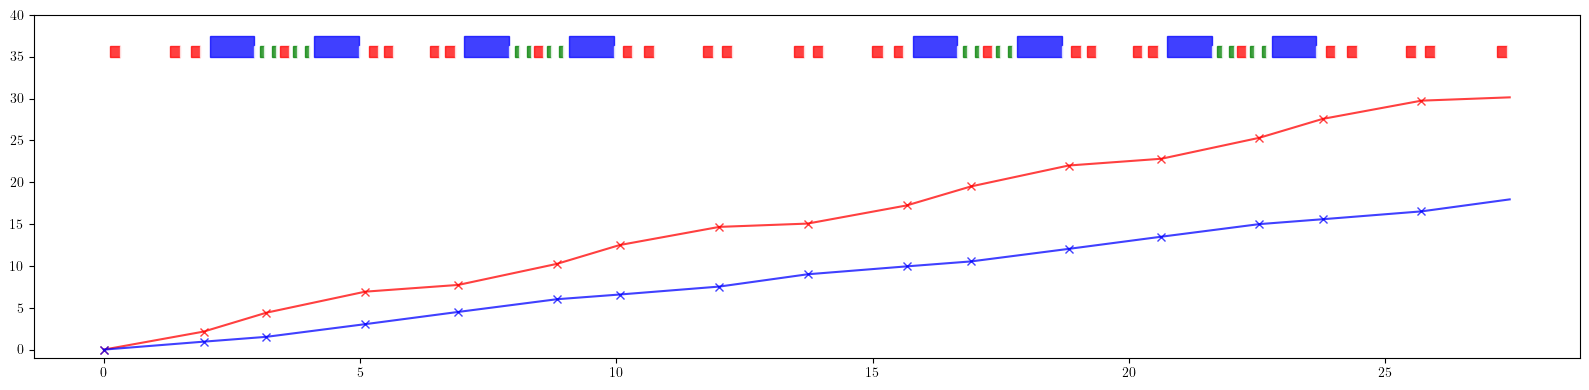

In [8]:
# Plot accumulated phase advances

muqx_sum = torch.cat([torch.tensor([0.0], dtype=torch.float64), muqx.cumsum(-1)])
muqy_sum = torch.cat([torch.tensor([0.0], dtype=torch.float64), muqy.cumsum(-1)])

# Compare

print(torch.allclose(muqx_sum[:-1], mu_qx))
print(torch.allclose(muqy_sum[:-1], mu_qy))

# Plot

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles = layout.profile_1d(scale=5.0, shift=35.0, text=False,  exclude=['BPM', 'Corrector'])

plt.figure(figsize=(16, 4))
plt.errorbar(positions, mu_qx.cpu().numpy(), fmt=' ', color='red', alpha=0.75, marker='x')
plt.errorbar(torch.cat([ring.locations(), ring.length.unsqueeze(-1)]).cpu().numpy(), muqx_sum.cpu().numpy(), fmt='-', color='red', alpha=0.75)
plt.errorbar(positions, mu_qy.cpu().numpy(), fmt=' ', color='blue', alpha=0.75, marker='x')
plt.errorbar(torch.cat([ring.locations(), ring.length.unsqueeze(-1)]).cpu().numpy(), muqy_sum.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-1.0, 40.0)
plt.tight_layout()
plt.show()